In [1]:
# chapter 5 figures when we rotate the task, fixing a learner
import numpy as np
import math

#---------------------------------------------------PARAMS----------------------------------------------------------
ROTATION_ANGLE = 360
ROT_MAT = np.zeros((360,2,2))

for i in range(360):
    d = float(i/180)*math.pi
    ROT_MAT[i] = np.array([[math.cos(d),  -math.sin(d)],
                         [math.sin(d), math.cos(d)]])
#-------------------------------------------------------------------------------------------------------------------
p = 0.02
W = int(1/p)+1
tau = np.hstack([np.arange(0.2, 20.0, 0.4),np.arange(20,100,4), np.arange(100,500,20)])
N_tau = np.size(tau)
epsilon = np.arange(51)*0.02
epsilon = np.around(epsilon, decimals = 3)
N_eps = np.size(epsilon)

def softmax(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            #print(weight[0], R, weight[1], T)
            temp = np.dot(weight, [R,T])/tau[n]
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax One"
    return P, learner

def selective_attention(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))/tau[n])
        ex_T = np.exp((T - np.max(T))/tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner



def hypervolume(R,T, refpoint):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            temp = np.zeros(4)
            for i in range(4):
                temp[i] = pow(abs(R[i] - np.min(R) +refpoint[0]), w*p/tau[n])*pow(abs(T[i] - np.min(T)+refpoint[1]), (1-w*p)/tau[n])
            #print(temp)
            P[w,n,:] = temp/np.sum(temp)
    learner = "Hypervolume"
    return P, learner

def eps_greedy(R,T):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*epsilon[n]
                else:
                    P[w,n,i] = 0.25*epsilon[n]
    
    learner = "Epsilon-Greedy"
    return P, learner
# below runs everything in reward-threat space        
def run(decision_maker, R,T, WEIGHT, TAU):
    if decision_maker!=eps_greedy:
        prob, learner_type = decision_maker(R,T)

        reward = np.dot(prob[WEIGHT,TAU], R)
        threat = np.dot(prob[WEIGHT,TAU], T)
    else:
        prob, learner_type = decision_maker(R,T)

        reward = np.dot(prob[WEIGHT,TAU], R)
        threat = np.dot(prob[WEIGHT,TAU], T)        
    return reward, threat

# fixed w and run over tau
def run_tau(decision_maker, R, T, WEIGHT):
    if decision_maker!=eps_greedy:
        prob, leaner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        reward_regret = np.max(R) - np.dot(prob[WEIGHT,:], R)
        threat_regret = np.max(T) - np.dot(prob[WEIGHT,:], T)
    else:
        prob, leaner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        reward_regret = np.max(R) - np.dot(prob[WEIGHT,:], R)
        threat_regret = np.max(T) - np.dot(prob[WEIGHT,:], T)        
    return reward_regret, threat_regret
        
def run_all(decision_maker, R,T):
    if decision_maker!=eps_greedy:
        reward_regret = np.zeros((W,N_tau))
        threat_regret = np.zeros((W,N_tau))
        prob, learner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        for w in range(W):
            for n in range(N_tau):
                reward_regret[w,n] = max_reward - np.dot(prob[w,n], R)
                threat_regret[w,n] = max_threat - np.dot(prob[w,n], T)
    else:
        reward_regret = np.zeros((W,N_eps))
        threat_regret = np.zeros((W,N_eps))
        prob, learner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        for w in range(W):
            for n in range(N_eps):
                reward_regret[w,n] = max_reward - np.dot(prob[w,n], R)
                threat_regret[w,n] = max_threat - np.dot(prob[w,n], T)        
    return reward_regret, threat_regret



# helper rotator function here
# rotate point by angle based on center
def rotate(x, y, i):
    L = len(x)
    p = np.array([x,y])
    #print(p)
    xx = np.mean(x)
    yy = np.mean(y)
    m = np.zeros((2,L))
    for l in range(L):
        m[0,l] = xx
        m[1,l] = yy
    #print(m)
    rotated = np.dot(ROT_MAT[i], np.array([x,y]) - m) + m
    return np.array(rotated)
# given 4 points in reward-threat space, counts how many of them are on the Pareto boundary
def pareto_counter(x,y):
    count = 0
    for i in range(4):
        count_i = 0
        for j in range(4):
            if x[j]>x[i] and y[j]>y[i]:
                count_i+=1

        if count_i == 0:

            count+=1
    return count

pareto_counter([0,1,4,10],[10,4,1,0])


4

4
3
2
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 157, 158, 159, 160, 161, 162, 163, 164, 165, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345]
[47.125 10.625 10.625 57.125]
-11.308108228915486 3.8081082289154873
-1.8081082289154873 13.308108228915486


<Figure size 432x288 with 0 Axes>

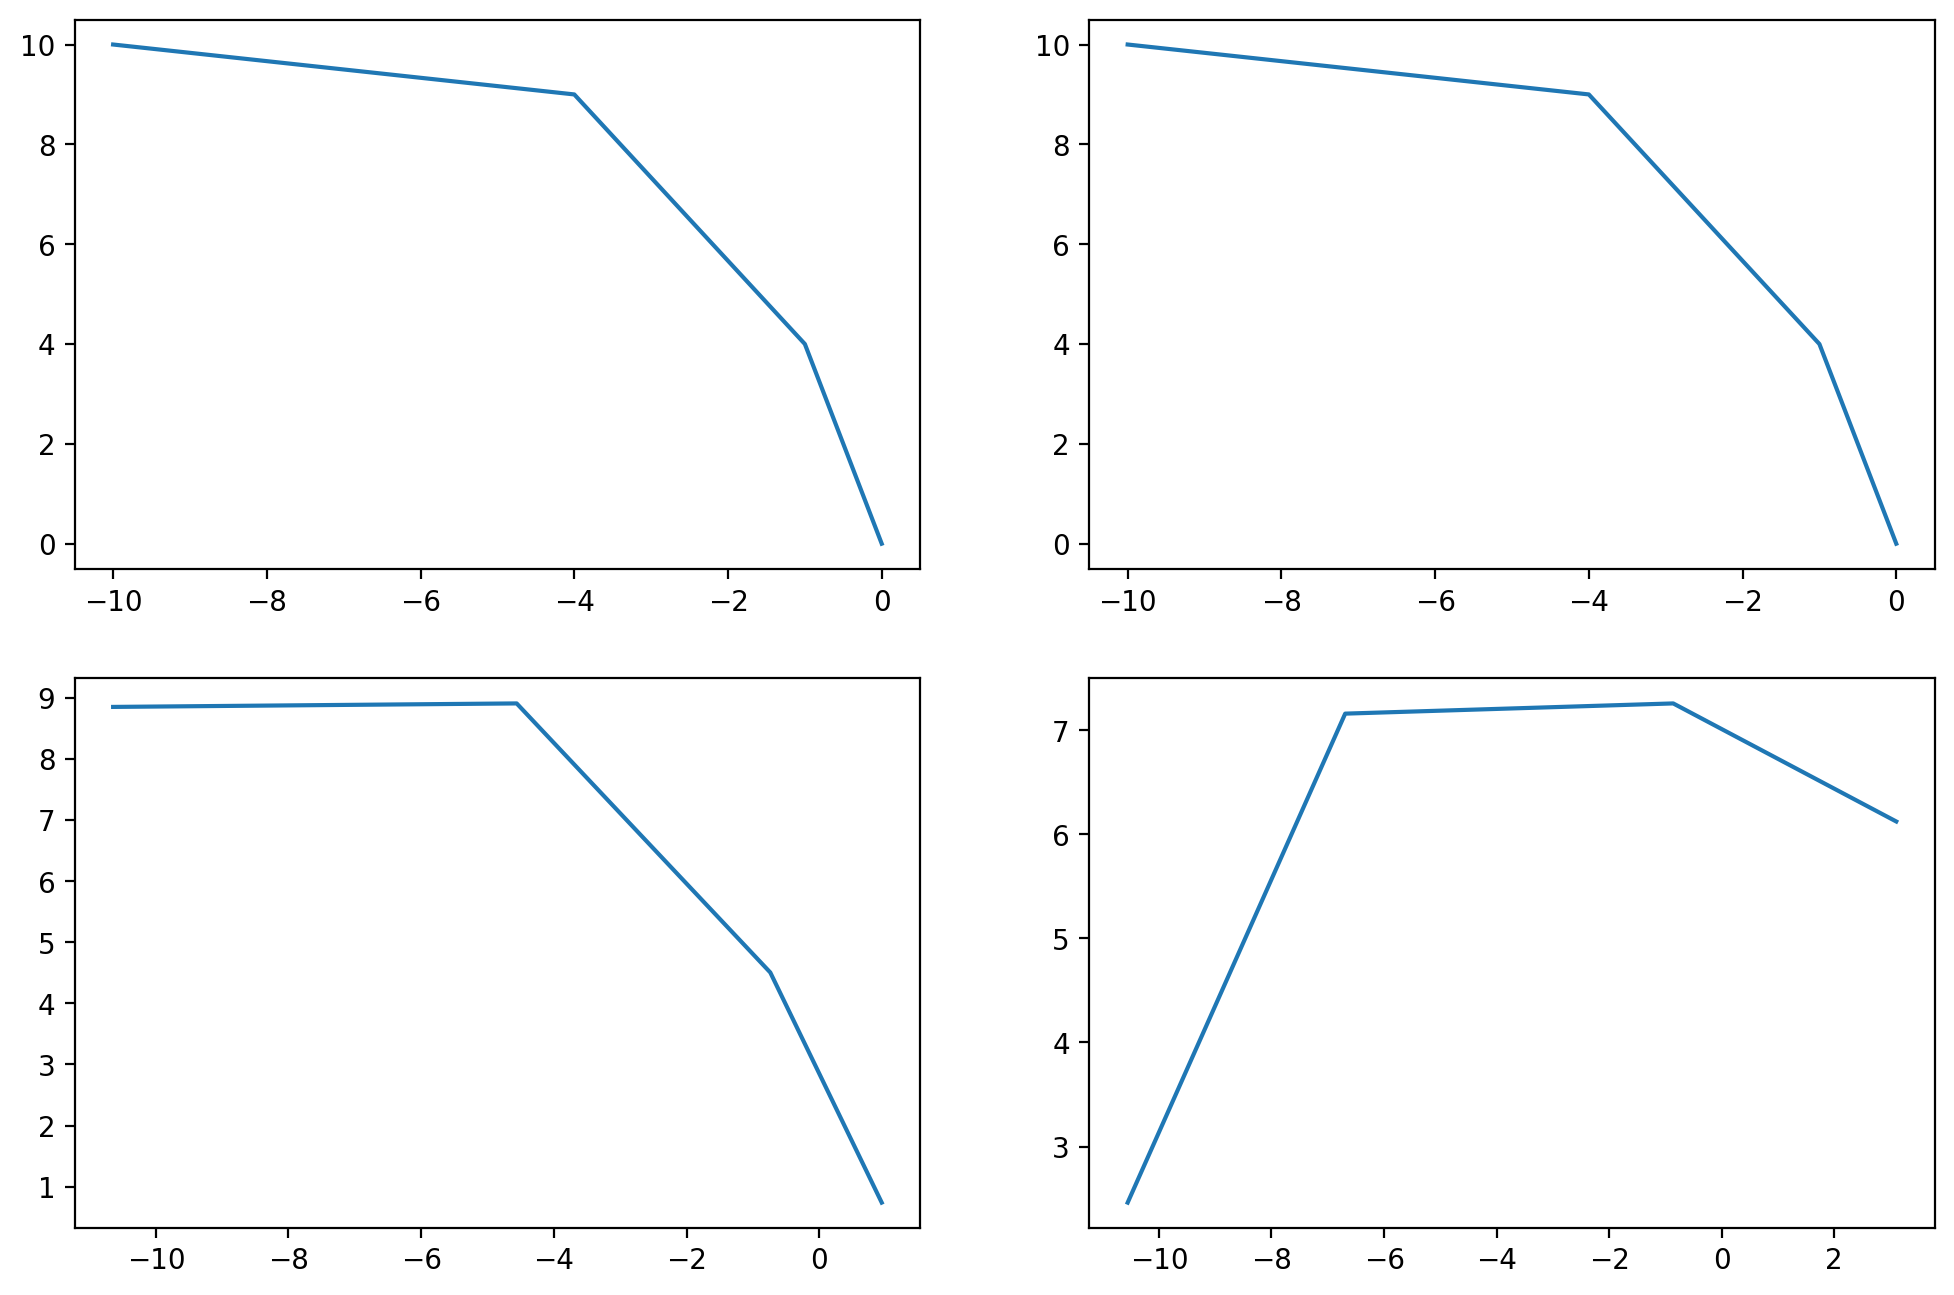

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



plt.figure(0)

# threshold values of angles that changes number of vertices on pareto front
pure_thr = [0,1,4,10]
pure_rew = [10,6,1,0]
R = [0,4,9,10]
T = [0,-1,-4,-10]
R_rotated = np.zeros((4,360))
T_rotated = np.zeros((4,360))
for i in range(360):
    T_rotated[:,i], R_rotated[:,i] = rotate(T,R,i)
#     plt.axis('scaled')
#     for j in range(4):
#         plt.plot(T_rotated[j,i], R_rotated[j,i],"-o", color = 'black')

max_R = np.amax(R_rotated, axis = 0)
max_T = np.amax(T_rotated, axis = 0)
# starting position has 4 pareto points
threshold = []
i = 0
for j in range(3):
    while(i<360):
        x,y = rotate(T,R,i)
        if pareto_counter(x,y)==4-j:
            threshold.append(i)
            print(pareto_counter(x,y))
            break
        else:
            i+=1


threshold.insert(0,0)
plt.figure(figsize = (12,8), dpi = 200)
for i in range(4):
    x,y = rotate(T,R,threshold[i])
    plt.subplot(2,2,i+1)
    plt.plot(x,y)

pareto_bound = [[],[],[],[]]
for i in range(360):
    x,y = rotate(T,R,i)
    pareto_bound[pareto_counter(x,y)-1].append(i)
print(pareto_bound[2])

centre_x = np.mean(T)
centre_y = np.mean(R)
radii = np.square(centre_x-T)+np.square(centre_y-R)
print(radii)
max_radius = np.sqrt(np.amax(radii))
max_radius
# for plotting purposes
# finding maximum x,y coordinates over 360 rotation
x_min = centre_x - max_radius
x_max = centre_x + max_radius
y_min = centre_y - max_radius
y_max = centre_y + max_radius
print(x_min, x_max)
print(y_min, y_max)

-3.9899999999999998 8.870000000000001
-3.3867898106239522 7.370759368298296
-4.348 5.455


Text(0.5, 0.98, 'w = 0.5, tau = 2 with angle = 360')

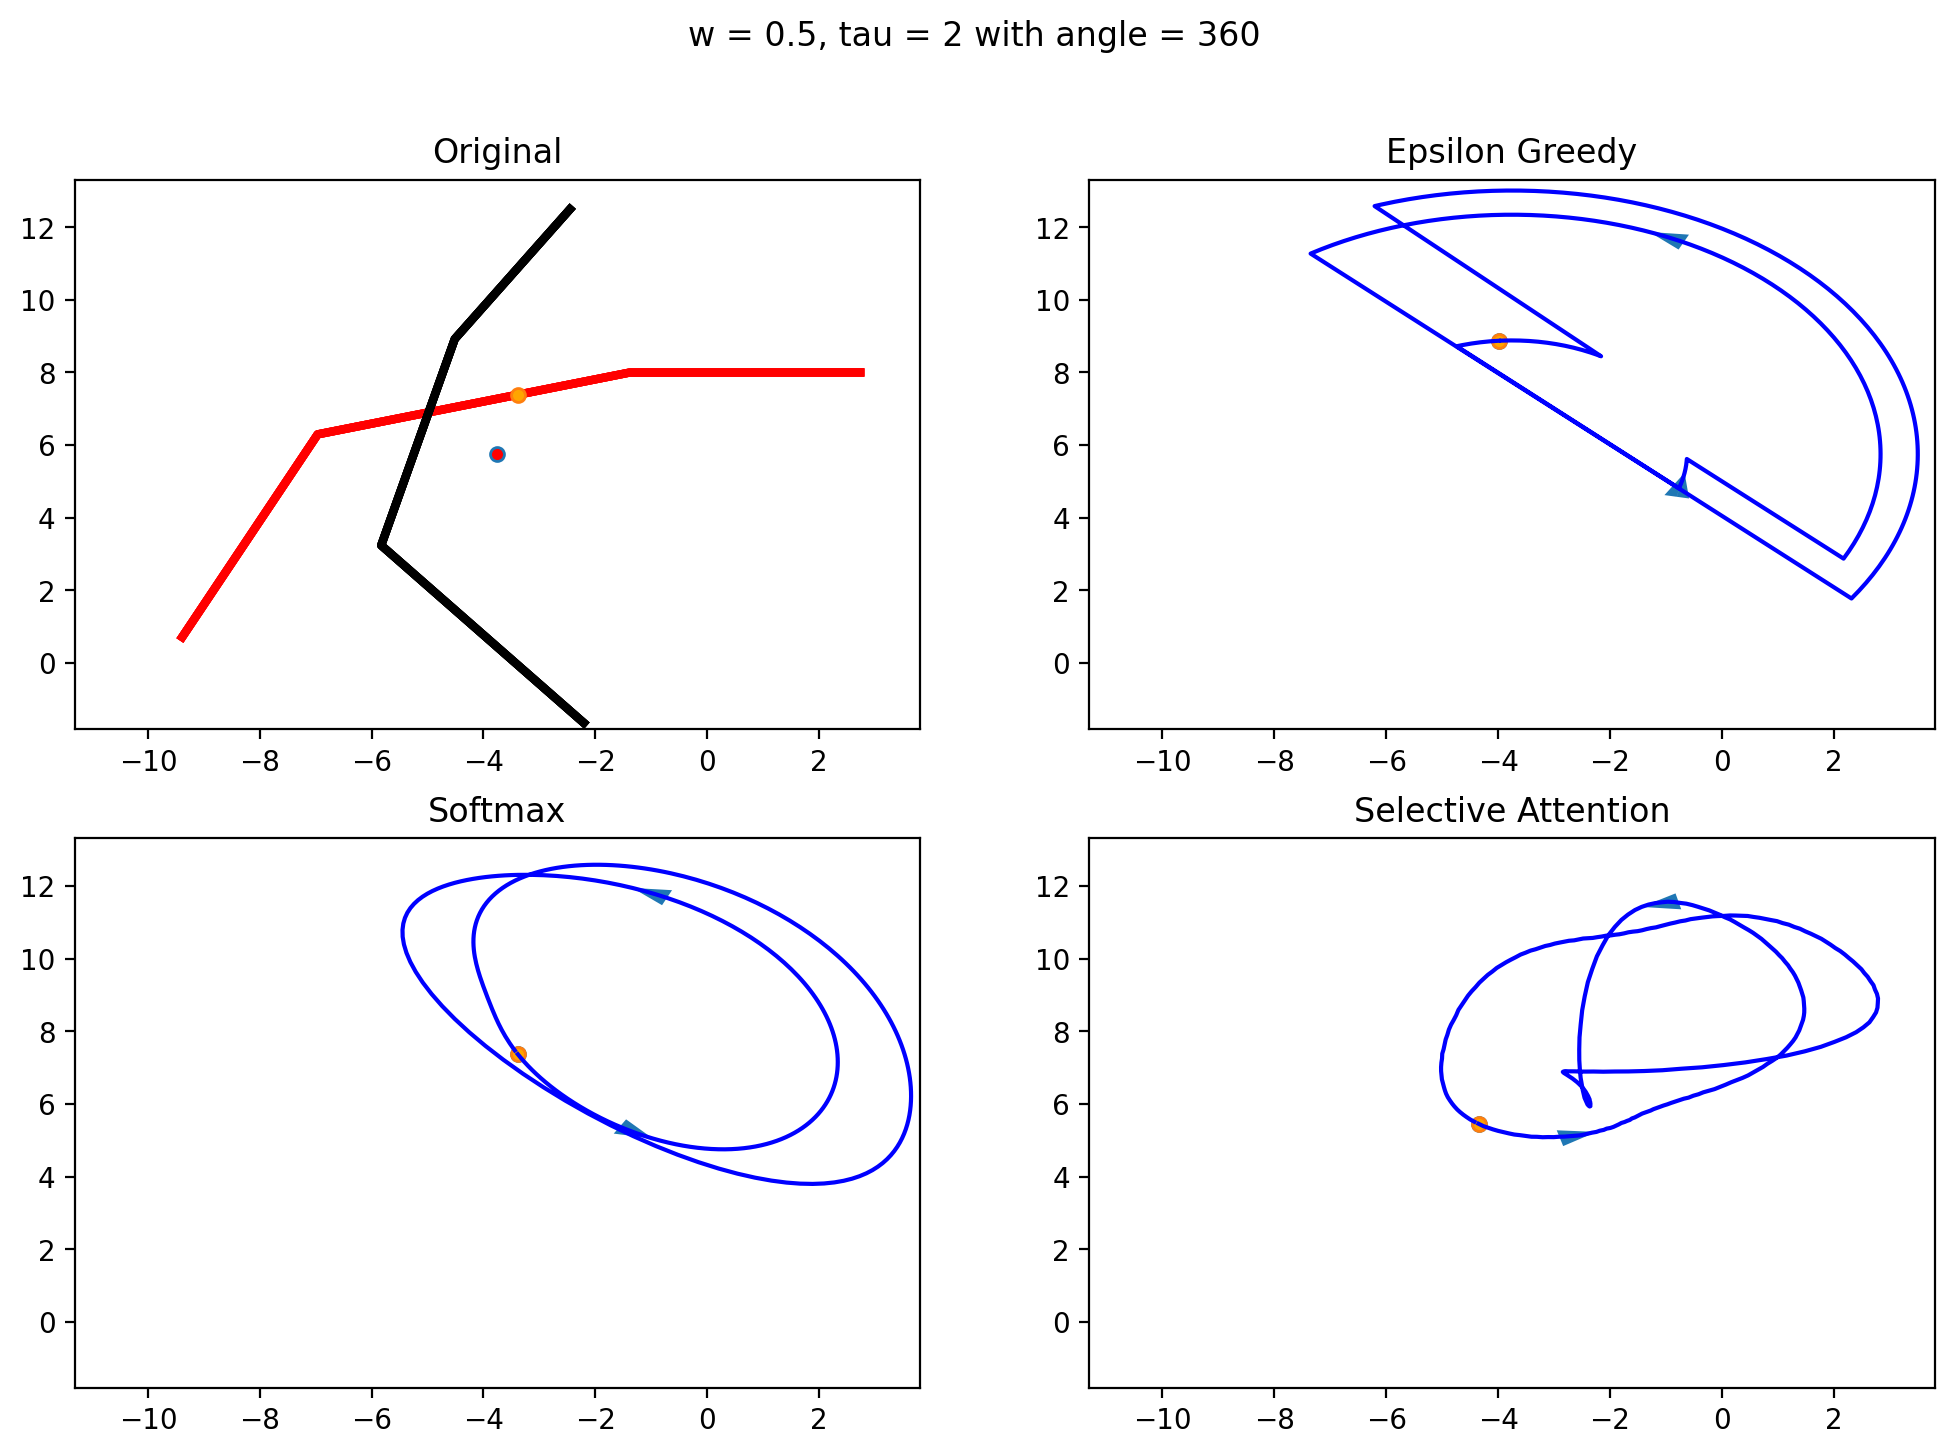

In [3]:
# plotting everything in reward-threat space 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=200)
TAU = 2
WEIGHT = 25


#----------------------Simply Plotting the Feasible Region for all vertices are Pareto Optimal--------------------------
#----------------------k = 0--------------------------------------------------------------------------------------------
plt.subplot(2,2,1)
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
centroid = [np.mean(T), np.mean(R)]
coordinates = [[T[k], R[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Original")
for i in range(4):
    plt.plot(T_rotated[:,76], R_rotated[:,76], color = 'red', linewidth = 3)
for i in range(4):
    plt.plot(T_rotated[:,136], R_rotated[:,136], color = 'black', linewidth = 3)    
reward_regret, threat_regret = run_all(softmax, R, T)
X = 0 - threat_regret
Y = 10 - reward_regret

# plt.plot(X[0,:], Y[0,:], color = 'black')
# plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - selective attention
decision_makers = [eps_greedy, softmax, selective_attention]
labels = ["Epsilon Greedy", "Softmax", "Selective Attention"]

for j in range(3):
    reward_regret, threat_regret = run_all(decision_makers[j], R, T)
    X = 0 - threat_regret
    Y = 10 - reward_regret
    plt.subplot(2,2,j+2)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
    print(X[WEIGHT, TAU], Y[WEIGHT, TAU])
    x = np.zeros(ROTATION_ANGLE)
    y = np.zeros(ROTATION_ANGLE)
    plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
    for i in range(ROTATION_ANGLE):
        y[i],x[i] = run(decision_makers[j], R_rotated[:,i],T_rotated[:,i], WEIGHT, TAU)
        
    
    # plt.plot(x[76:136], y[76:136], color = 'blue') 
    plt.plot(x, y, color = 'blue') 
#     plt.plot(x,y, color = 'black')
    plt.title(labels[j])
    a = int(ROTATION_ANGLE/20)
    b = int(ROTATION_ANGLE/3)
    plt.arrow(x[a], y[a], x[a+5]-x[a], y[a+5]-y[a], shape='full', lw=0, length_includes_head=True, head_width=.45)
    plt.arrow(x[b], y[b], x[b+5]-x[b], y[b+5]-y[b], shape='full', lw=0, length_includes_head=True, head_width=.45)
#plt.axis('scaled')    
plt.suptitle("w = " + str(WEIGHT/50)+", tau = " +str(TAU) + " with angle = "+ str(ROTATION_ANGLE))

Text(0.5, 0.98, 'w = 0.5, tau = 2 with angle = 360')

<Figure size 1600x1000 with 0 Axes>

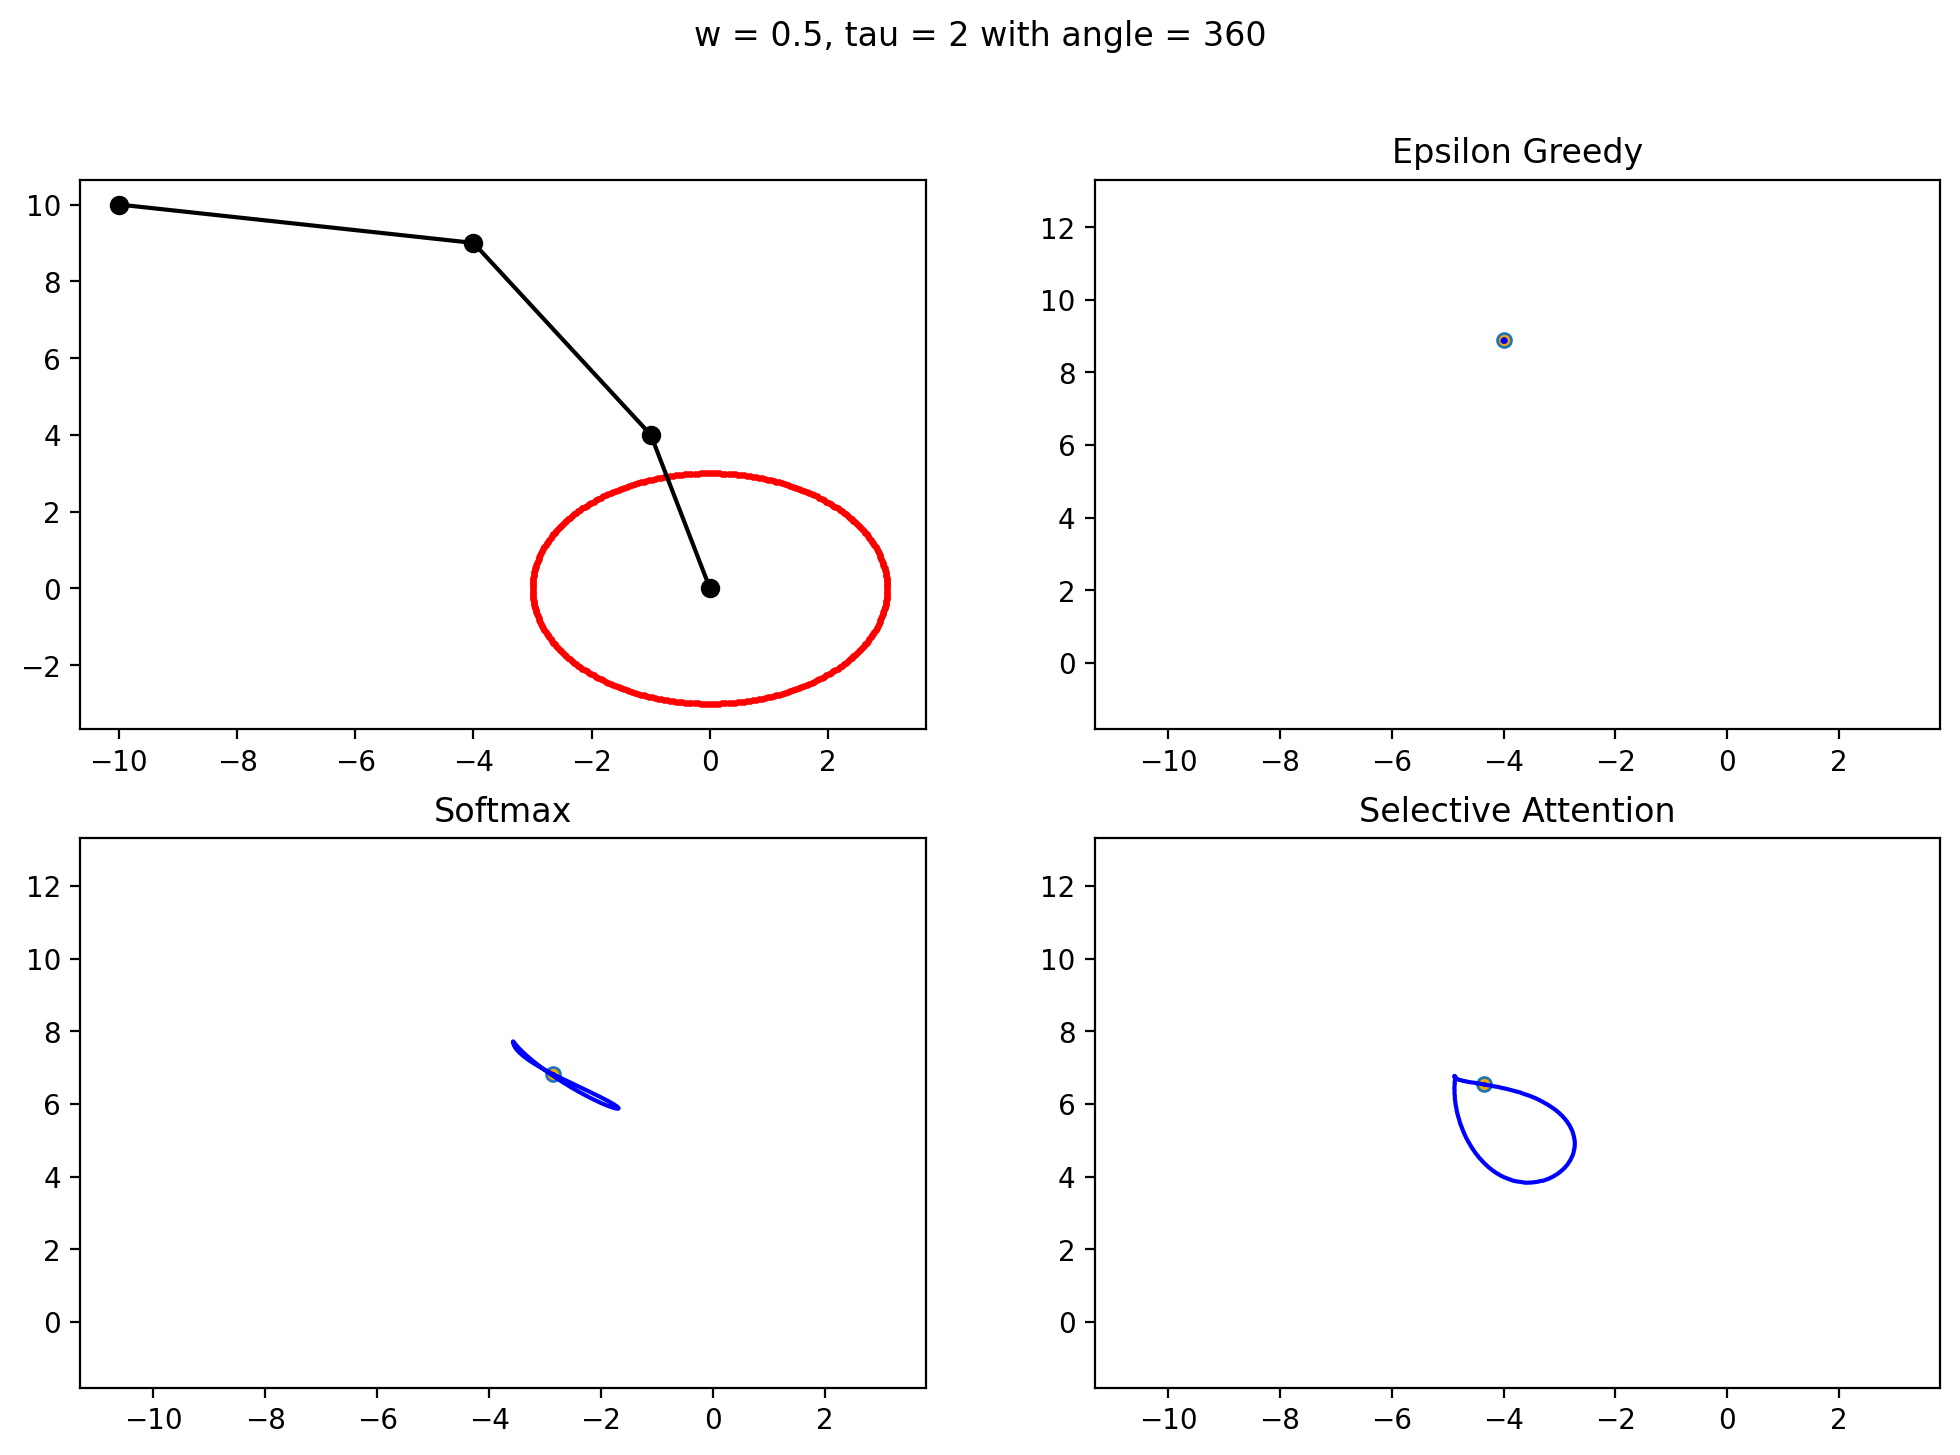

In [4]:
# perturbing a single vertex here
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 5), dpi=200)
R = [0,4,9,10]
T = [0,-1,-4,-10]
rad = 3.0
def rotate(x, y, i):
    L = len(x)
    p = np.array([x,y])
    #print(p)
    xx = np.mean(x)
    yy = np.mean(y)
    m = np.zeros((2,L))
    for l in range(L):
        m[0,l] = xx
        m[1,l] = yy
    #print(m)
    rotated = np.dot(ROT_MAT[i], np.array([x,y]) - m) + m
    return np.array(rotated)

def perturb(T,R, i, r):
    # T,R are the rewards and i is index being perturbed with radius r
    T_p = np.zeros((360,4))
    R_p = np.zeros((360,4))
    
    # ref is the starting point of the rotation
    ref = np.array([T[i], R[i]+r])
    center = np.array([T[i], R[i]])
    for j in range(360):
        T_p[j,:] = T
        R_p[j,:] = R
        temp = np.dot(ROT_MAT[j], ref - center) + center
        T_p[j,i] = temp[0]
        R_p[j,i] = temp[1]
    return T_p, R_p


plt.figure(1)
figure(figsize=(12, 8), dpi=200)
T_p,R_p = perturb(T,R,0,rad)
plt.subplot(2,2,1)

for i in range(360):
    plt.scatter(T_p[i,:], R_p[i,:],s = 2, color = 'red' )
plt.plot(T,R,"-o", color = 'black')


for j in range(3):
    plt.subplot(2,2,j+2)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    reward_regret, threat_regret = run_all(decision_makers[j], R_p[0,:], T_p[0,:])
    X = np.amax(T_p[0,:]) - threat_regret
    Y = np.amax(R_p[0,:]) - reward_regret
    plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
    x = np.zeros(ROTATION_ANGLE)
    y = np.zeros(ROTATION_ANGLE)

    for i in range(ROTATION_ANGLE):
        y[i],x[i] = run(decision_makers[j], R_p[i,:],T_p[i,:], WEIGHT, TAU)

    plt.plot(x, y, color = 'blue') 
    plt.title(labels[j])
plt.suptitle("w = " + str(WEIGHT/50)+", tau = " +str(TAU) + " with angle = "+ str(ROTATION_ANGLE))

Text(0.5, 0.98, 'w = 0.5, tau = 2 with angle = 360')

<Figure size 432x288 with 0 Axes>

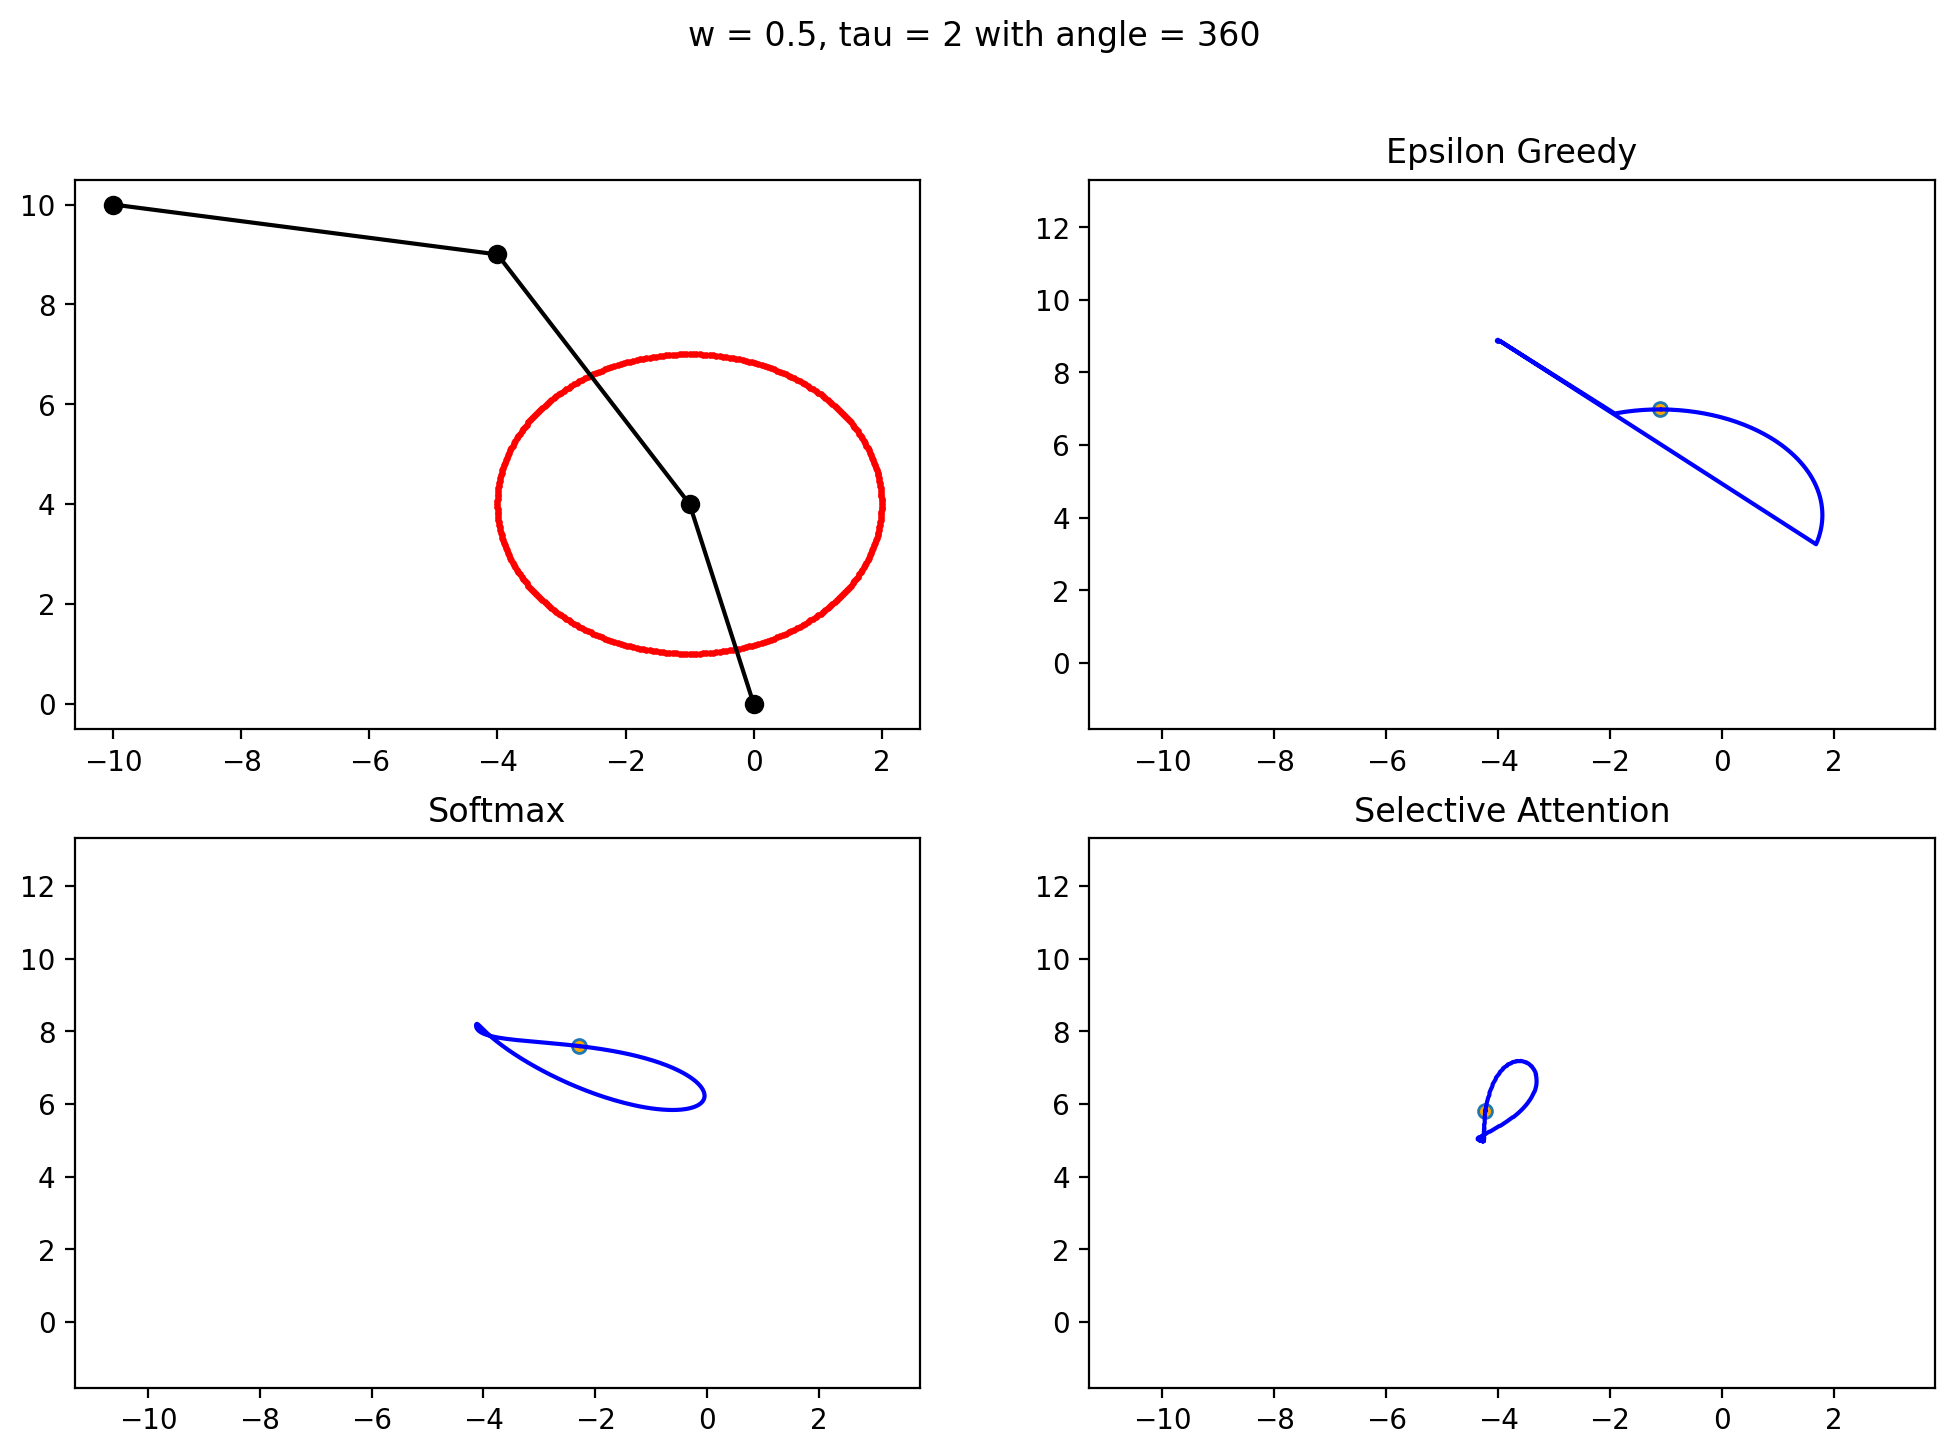

In [5]:
plt.figure(2)
figure(figsize=(12, 8), dpi=200)
T_p,R_p = perturb(T,R,1,rad)
plt.subplot(2,2,1)

for i in range(360):
    plt.scatter(T_p[i,:], R_p[i,:],s = 2, color = 'red' )
plt.plot(T,R,"-o", color = 'black')


for j in range(3):
    plt.subplot(2,2,j+2)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    reward_regret, threat_regret = run_all(decision_makers[j], R_p[0,:], T_p[0,:])
    X = np.amax(T_p[0,:]) - threat_regret
    Y = np.amax(R_p[0,:]) - reward_regret
    plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
    x = np.zeros(ROTATION_ANGLE)
    y = np.zeros(ROTATION_ANGLE)

    for i in range(ROTATION_ANGLE):
        y[i],x[i] = run(decision_makers[j], R_p[i,:],T_p[i,:], WEIGHT, TAU)

    plt.plot(x, y, color = 'blue') 
    plt.title(labels[j])
plt.suptitle("w = " + str(WEIGHT/50)+", tau = " +str(TAU) + " with angle = "+ str(ROTATION_ANGLE))

Text(0.5, 0.98, 'w = 0.5, tau = 2 with angle = 360')

<Figure size 432x288 with 0 Axes>

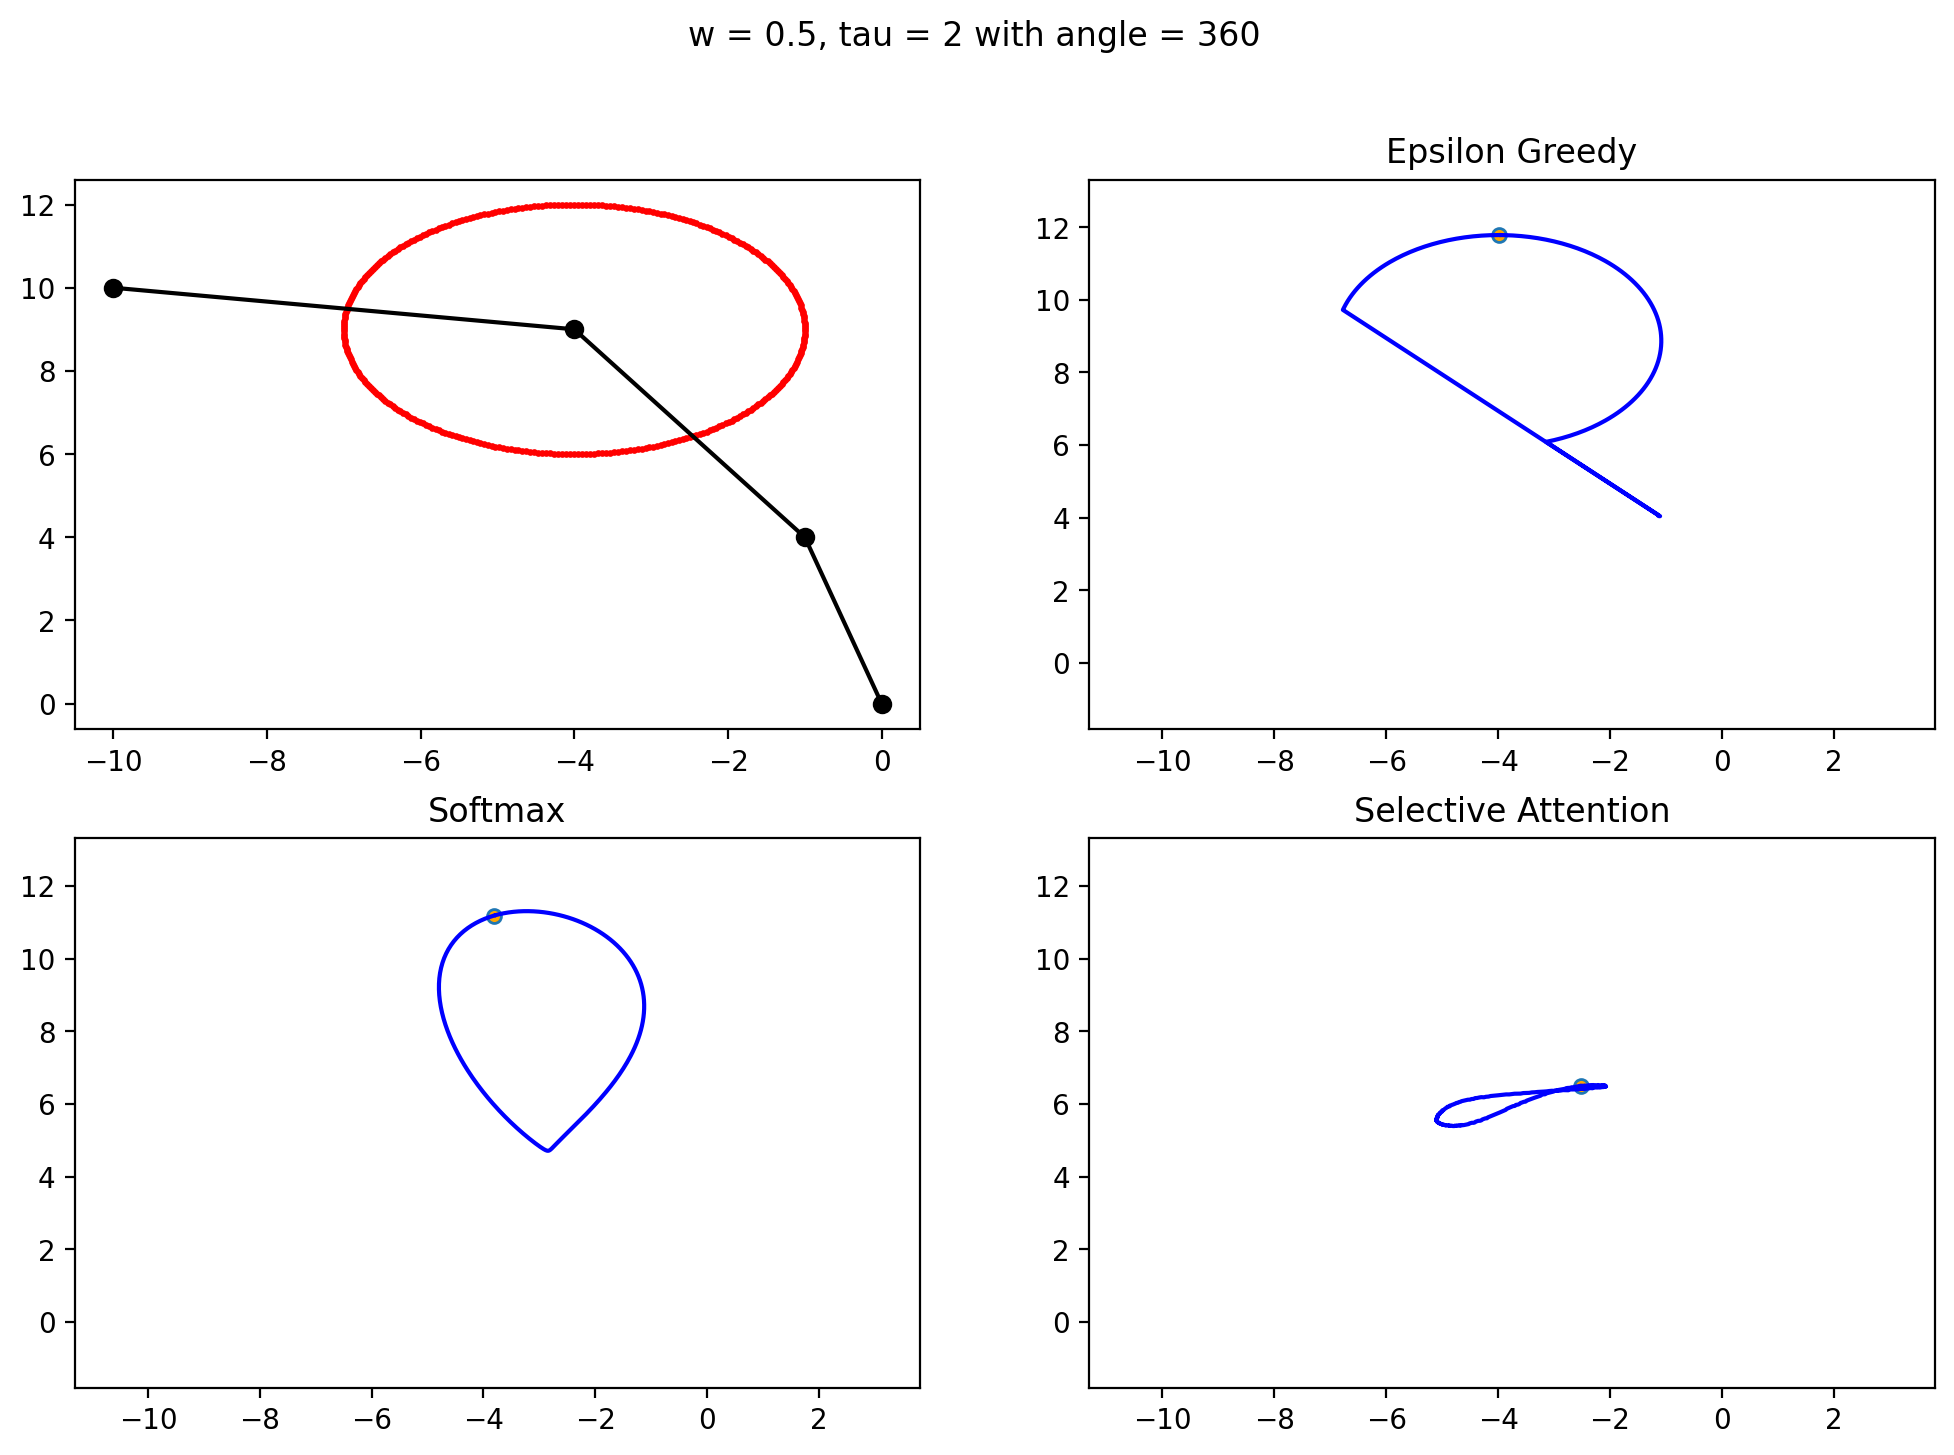

In [6]:
plt.figure(3)
figure(figsize=(12, 8), dpi=200)
T_p,R_p = perturb(T,R,2,rad)
plt.subplot(2,2,1)

for i in range(360):
    plt.scatter(T_p[i,:], R_p[i,:],s = 2, color = 'red' )
plt.plot(T,R,"-o", color = 'black')


for j in range(3):
    plt.subplot(2,2,j+2)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    reward_regret, threat_regret = run_all(decision_makers[j], R_p[0,:], T_p[0,:])
    X = np.amax(T_p[0,:]) - threat_regret
    Y = np.amax(R_p[0,:]) - reward_regret
    plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
    x = np.zeros(ROTATION_ANGLE)
    y = np.zeros(ROTATION_ANGLE)

    for i in range(ROTATION_ANGLE):
        y[i],x[i] = run(decision_makers[j], R_p[i,:],T_p[i,:], WEIGHT, TAU)

    plt.plot(x, y, color = 'blue') 
    plt.title(labels[j])
plt.suptitle("w = " + str(WEIGHT/50)+", tau = " +str(TAU) + " with angle = "+ str(ROTATION_ANGLE))

Text(0.5, 0.98, 'w = 0.5, tau = 2 with angle = 360')

<Figure size 432x288 with 0 Axes>

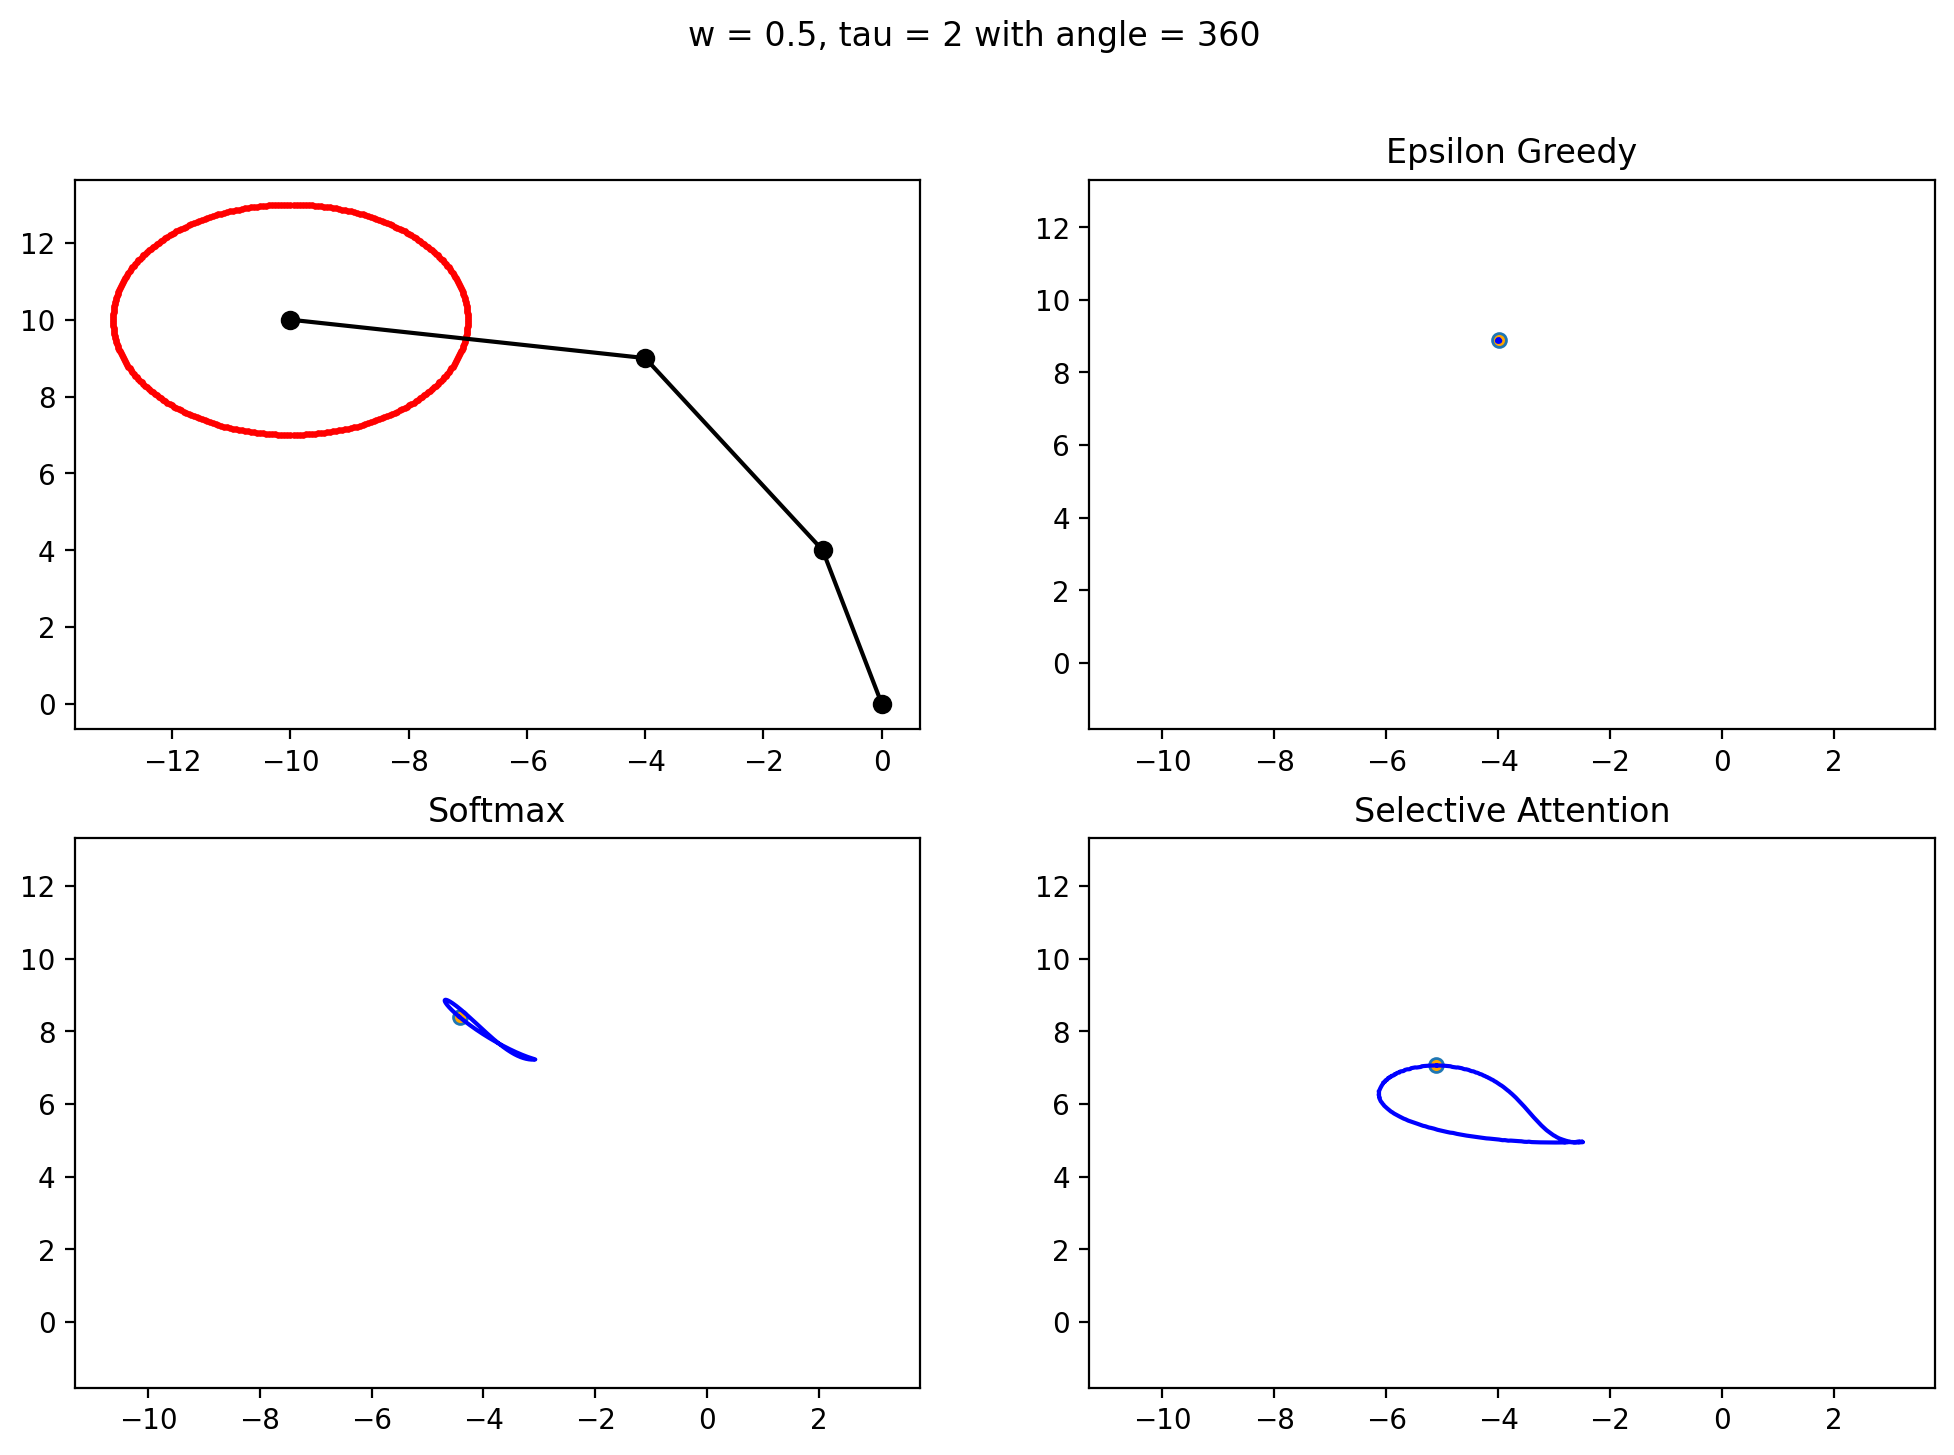

In [7]:
plt.figure(4)
figure(figsize=(12, 8), dpi=200)
T_p,R_p = perturb(T,R,3,rad)
plt.subplot(2,2,1)

for i in range(360):
    plt.scatter(T_p[i,:], R_p[i,:],s = 2, color = 'red' )
plt.plot(T,R,"-o", color = 'black')


for j in range(3):
    plt.subplot(2,2,j+2)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    reward_regret, threat_regret = run_all(decision_makers[j], R_p[0,:], T_p[0,:])
    X = np.amax(T_p[0,:]) - threat_regret
    Y = np.amax(R_p[0,:]) - reward_regret
    plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")
    x = np.zeros(ROTATION_ANGLE)
    y = np.zeros(ROTATION_ANGLE)

    for i in range(ROTATION_ANGLE):
        y[i],x[i] = run(decision_makers[j], R_p[i,:],T_p[i,:], WEIGHT, TAU)

    plt.plot(x, y, color = 'blue') 
    plt.title(labels[j])
plt.suptitle("w = " + str(WEIGHT/50)+", tau = " +str(TAU) + " with angle = "+ str(ROTATION_ANGLE))

-4.55789317260294 7.481097589033672  this is the learner given by eps-greedy
[0.83935798 0.53428696]  this is (w, tau) solved by SA solver for the given eps_greedy learner
(-4.557893172700339, 7.481097589023468)  this is checking if the above SA solver is working correctly. Should give same values
[0.72603107 1.32590472]  this is (w, tau) value solved by SM solver for the given eps_greedy learner
(-4.557893172602806, 7.481097589033599)  this is checking if the above SM solver is working correctly. Should give same values


<Figure size 432x288 with 0 Axes>

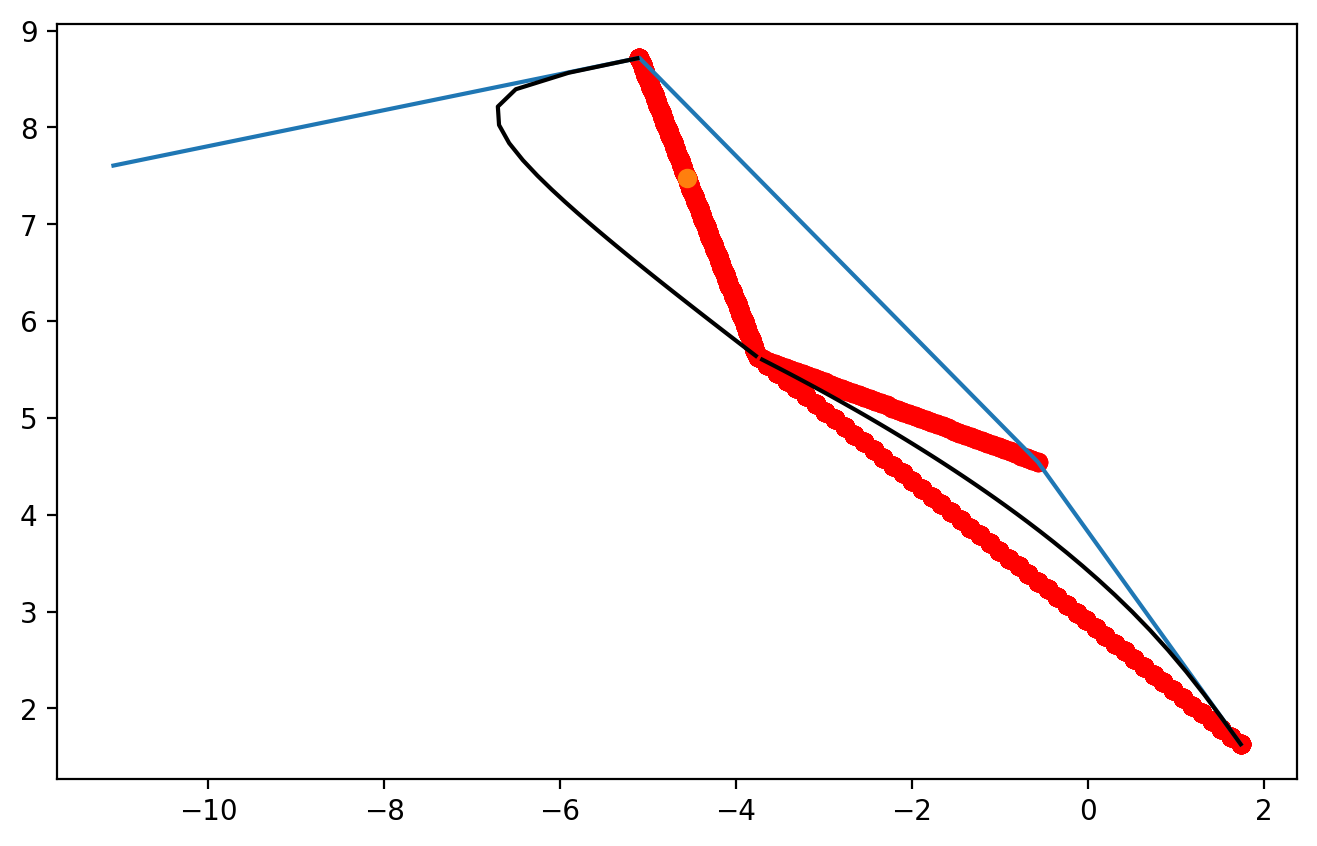

In [8]:
# implementing fsolve directly with 2 variables
# this cell is only for SA given eps greedy
import math
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(5)
figure(figsize=(8, 5), dpi=200)
rad = 0.5
WEIGHT = 35
EPSILON = 20
y = 5.455
x = -4.348
R = np.array([0,4,9,10])
T = np.array([0,-1,-4,-10])
T,R = rotate(T,R,180)
def w_plus(t, reward):
    temp = np.exp(reward/t)
    temp = temp/np.sum(temp)
    return temp
def w_minus(t, threat):
    temp = np.exp(threat/t)
    temp = temp/np.sum(temp)
    return temp
def f_SA(variables, *data) :
    x,y = data
    (w,tau) = variables
    w_p = w_plus(tau, R)
    w_m = w_minus(tau, T)
    weighted_sum = w*w_p + (1-w)*w_m
    
    first_eq = np.dot(weighted_sum, R) - y
    second_eq = np.dot(weighted_sum, T) - x
    return [first_eq, second_eq]

# first we run eps_greedy to get a point-------------
# then we solve for Softmax parameters
# then we solve for Selective Attention
T,R = rotate(T,R,200)
T_p, R_p = perturb(T,R,1,rad)
rew_regret, thr_regret = run_all(eps_greedy,R_p[180,:],T_p[180,:])
eps_reward = np.amax(R_p[180,:]) - rew_regret
eps_threat = np.amax(T_p[180,:]) - thr_regret
print(eps_threat[WEIGHT, EPSILON], eps_reward[WEIGHT, EPSILON], " this is the learner given by eps-greedy")

R[1]-=rad

plt.plot(T,R)
plt.plot(eps_threat[WEIGHT, EPSILON], eps_reward[WEIGHT, EPSILON], '-o')
# this is the point we are now going to solve for w, tau values for softmax and SA
y = eps_reward[WEIGHT, EPSILON]
x = eps_threat[WEIGHT, EPSILON]
sa_solution = scipy.optimize.fsolve(f_SA, (0.7, 2),(x,y)) # this gives (w,tau) for which SA gives given eps_greedy point shown in green
print(sa_solution, " this is (w, tau) solved by SA solver for the given eps_greedy learner")


plt.scatter(eps_threat, eps_reward, color = 'red')
rew_regret, thr_regret = run_all(selective_attention,R,T)
eps_reward = np.amax(R) - rew_regret
eps_threat = np.amax(T) - thr_regret
#plt.scatter(eps_threat, eps_reward, color = 'orange')

# single given value solver for SA
def sa_solver(R, T, w, tau):
    R_plus = np.exp(R/tau)/np.sum(np.exp(R/tau))
    T_plus = np.exp(T/tau)/np.sum(np.exp(T/tau))
    temp = w*R_plus +(1-w)*T_plus
    y_value = np.dot(temp, R)
    x_value = np.dot(temp, T)
    return x_value, y_value
print(sa_solver(R,T,sa_solution[0], sa_solution[1]), " this is checking if the above SA solver is working correctly. Should give same values")

# single given value solver for SM
def sm_solver(R, T, w, tau):
    temp = (w*R + (1-w)*T)/tau
    probs = np.exp(temp)/np.sum(np.exp(temp))
    y_value = np.dot(probs, R)
    x_value = np.dot(probs, T)
    return x_value, y_value
# single given value solver of eps_greedy
def eps_solver(R,T, w, eps_n):
    k = np.argmax(w*R + (1-w)*T)
    probs = np.zeros(4)
    for i in range(4):
        if i==k:
            probs[i] = 1-0.75*epsilon[eps_n]
        else:
            probs[i] = 0.25*epsilon[eps_n]
    y_value = np.dot(probs, R)
    x_value = np.dot(probs, T)
    return x_value, y_value

yy,xx = run_all(softmax, R, T)
yy = np.amax(R) - yy
xx = np.amax(T) - xx

# now write a solver for Softmax here given values x,y
def f_SM(variables, *data) :
    x,y = data
    (w,tau) = variables
    temp = (w*R + (1-w)*T)/tau
    probs = np.exp(temp)/np.sum(np.exp(temp))
    first_eq = np.dot(probs, R) - y
    second_eq = np.dot(probs, T) - x
    return [first_eq, second_eq]
sm_solution = scipy.optimize.fsolve(f_SM, (0.0,5), (x,y))
print(sm_solution, " this is (w, tau) value solved by SM solver for the given eps_greedy learner")
print(sm_solver(R,T,sm_solution[0], sm_solution[1]), " this is checking if the above SM solver is working correctly. Should give same values")
#plt.scatter(xx,yy, color = 'blue')
plt.plot(xx[0,:], yy[0,:], color = 'black')
plt.plot(xx[-1,:], yy[-1,:], color = 'black')

# all the solvers working correctly so far.
# below start perturbing and tracing out the individual curves



Text(0.5, 1.0, 'Selective Attention')

<Figure size 432x288 with 0 Axes>

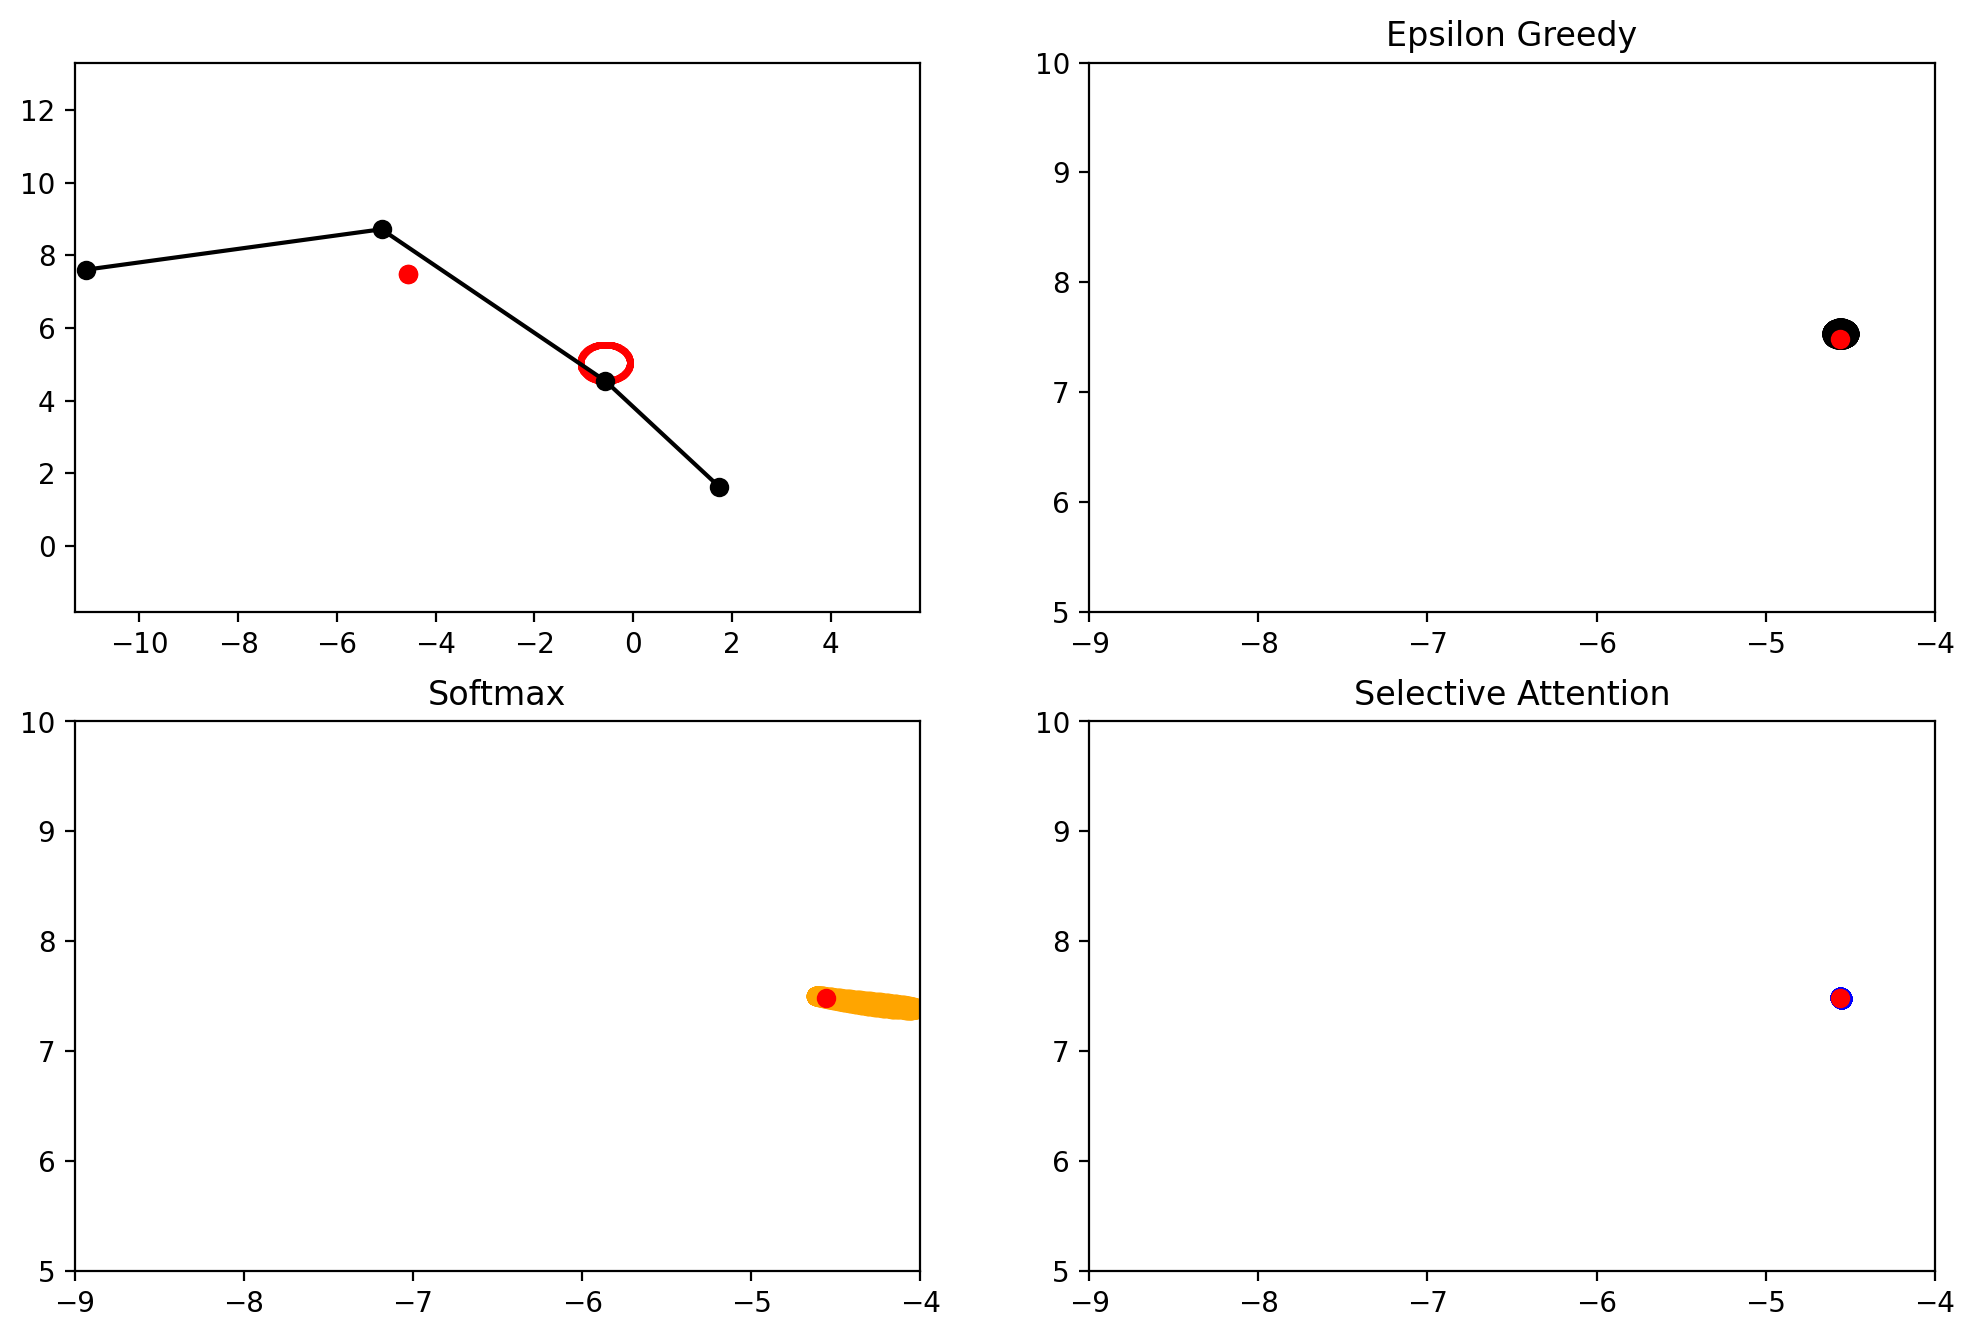

In [9]:
plt.figure(6)
figure(figsize=(12, 8), dpi=200)
#T_p,R_p = perturb(T,R,3,rad)
plt.subplot(2,2,1)
plt.plot(x, y, '-o', color = 'red')
for i in range(360):
    plt.scatter(T_p[i,:], R_p[i,:],s = 2, color = 'red' )
plt.plot(T,R,"-o", color = 'black')

ROTATION_ANGLE = 360

plt.xlim([x_min, x_max+2])
plt.ylim([y_min, y_max])
plt.plot(x, y, '-o', color = 'red')

# tracing out eps_greedy
y_eps = np.zeros(360)
x_eps = np.zeros(360)
for i in range(ROTATION_ANGLE):
    j = (i+180)%360
    x_eps[i], y_eps[i] = eps_solver(R_p[j,:], T_p[j,:], WEIGHT*p, EPSILON)
plt.subplot(2,2,2)
plt.xlim([-9, -4])
plt.ylim([5, 10])

plt.plot(x_eps[0:ROTATION_ANGLE], y_eps[0:ROTATION_ANGLE], "-o", color = 'black')
plt.plot(x, y, '-o', color = 'red')
plt.title(labels[0])

# tracing out softmax
y_sm = np.zeros(360)
x_sm = np.zeros(360)

for i in range(ROTATION_ANGLE):
    j = (i+180)%360
    x_sm[i], y_sm[i] = sm_solver(R_p[j,:], T_p[j,:], sm_solution[0], sm_solution[1])
plt.subplot(2,2,3)
plt.xlim([-9, -4])
plt.ylim([5, 10])


plt.plot(x_sm[0:ROTATION_ANGLE], y_sm[0:ROTATION_ANGLE], "-o", color = "orange")
plt.plot(x, y, '-o', color = 'red')
plt.title(labels[1])

# tracing out selective attention
y_sa = np.zeros(360)
x_sa = np.zeros(360)

for i in range(ROTATION_ANGLE):
    j = (i+180)%360
    x_sa[i], y_sa[i] = sa_solver(R_p[j,:], T_p[j,:], sa_solution[0], sa_solution[1])
plt.subplot(2,2,4)
plt.xlim([-9, -4])
plt.ylim([5, 10])


plt.plot(x_sa[0:ROTATION_ANGLE], y_sa[0:ROTATION_ANGLE], "-o", color = "blue")
plt.plot(x, y, '-o', color = 'red')
plt.title(labels[2])



<Figure size 432x288 with 0 Axes>

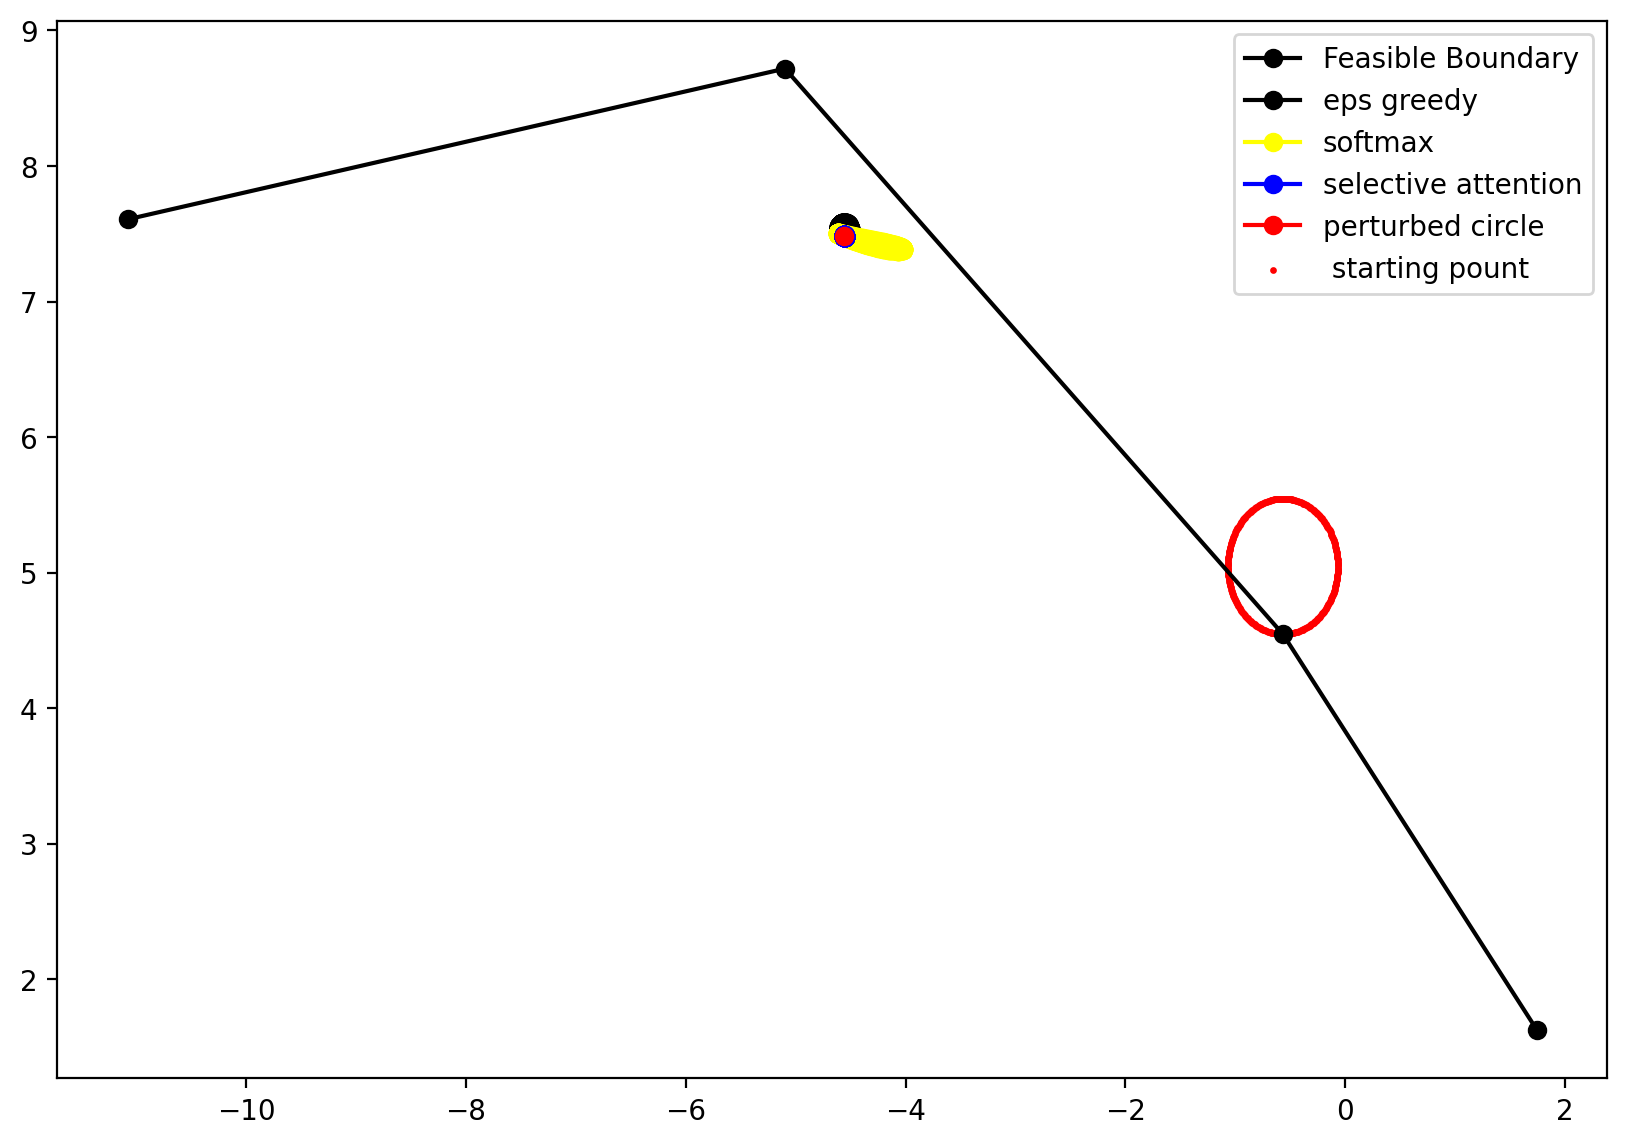

In [10]:
plt.figure(7)
figure(figsize=(10, 7), dpi=200)


for i in range(ROTATION_ANGLE):
    j = (i+180)%360
    plt.scatter(T_p[j,:], R_p[j,:],s = 2, color = 'red' )
plt.plot(T,R,"-o", color = 'black')
plt.plot(x_eps[0:ROTATION_ANGLE], y_eps[0:ROTATION_ANGLE], '-o', color = 'black')
plt.plot(x_sm[0:ROTATION_ANGLE], y_sm[0:ROTATION_ANGLE], "-o", color = 'yellow')
plt.plot(x_sa[0:ROTATION_ANGLE], y_sa[0:ROTATION_ANGLE], "-o", color = 'blue')
plt.plot(x, y, '-o', color = 'red')
plt.legend(["Feasible Boundary",  "eps greedy", "softmax", "selective attention","perturbed circle", " starting pount"])